In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [28]:
data = pd.read_csv('springfield.csv')#, index_col='date')
data['date'] = pd.to_datetime(data['date'])
data

,date,65807
0,1996-04-01,80800.0
1,1996-05-01,80800.0
2,1996-06-01,80900.0
3,1996-07-01,81100.0
4,1996-08-01,81400.0
...,...,...
260,2017-12-01,119900.0
261,2018-01-01,120500.0
262,2018-02-01,121400.0
263,2018-03-01,122800.0


In [29]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

def plot_df(df):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot('date', '65807', data=df)

    # Major ticks every 12 months.
    fmt_half_year = mdates.MonthLocator(interval=12)
    ax.xaxis.set_major_locator(fmt_half_year)

    # Text in the x axis will be displayed in 'YYYY-mm' format.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them.
    fig.autofmt_xdate()

    #plt.xticks(np.arange(0, len(data), step=35))
    plt.show()

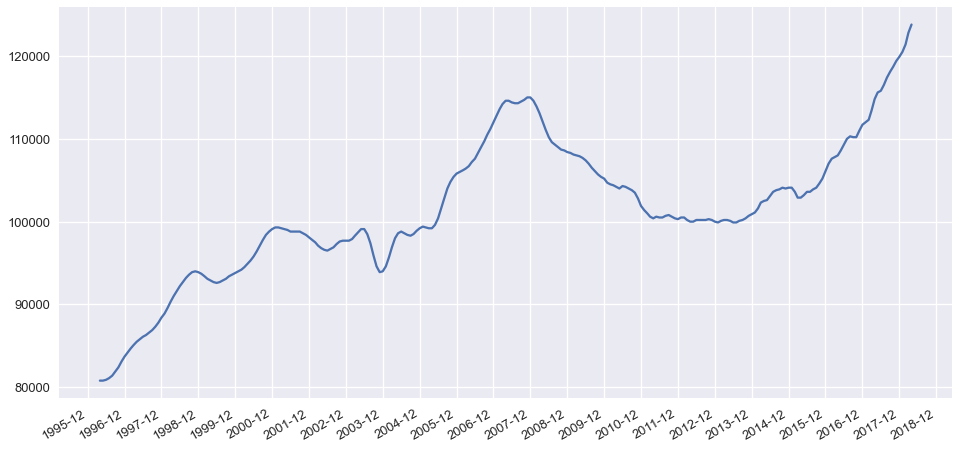

In [30]:
plot_df(data)

In [31]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [32]:
model = ARIMA(data.set_index('date'), order=(2, 2, 1), freq='MS').fit()

In [33]:
cross_validate(data.set_index('date'), (2, 2, 1))

[1866.9765454048647,
 1421.5151490804524,
 1110.086333972609,
 1290.5329330842123,
 770.2872621268094,
 1040.7258509076223,
 2050.7069318790013,
 1808.0487779564205,
 1365.0464727965789,
 1748.2333259121535,
 3812.2472929130586,
 2488.228961251706]

In [25]:
import numpy as np

def cross_validate(data, order, initial=12*15, horizon=12, period=6, verbose=False):
    k = (len(data)-initial-horizon)//period
    if verbose: print('Cross validating over', str(k), 'folds.')
    
    rmses = []
    for i in range(1, k+1):
        n = len(data)-horizon-((k-i)*period)
        model = ARIMA(data[:n], order=order, freq='MS').fit()
        y_hat = model.get_forecast(steps=horizon).predicted_mean.to_numpy()
        y = data[n:n+horizon].to_numpy()
        rmse = np.sqrt(mean_squared_error(y, y_hat))
        if verbose: print(f'fold {i}: train[0:{n}], test[{n}:{n+horizon}] of {len(data)}, rmse={rmse}')
        rmses.append(rmse)

    return rmses

In [ ]:
def arima_analyze(data, order, initial=12*15, horizon=12, period=6, forecast_length=24, filename=None):
    
    forecast_index = pd.date_range(data.index[-1], periods=forecast_length+1, freq='MS')[1:]
    forecast_df = pd.DataFrame(index=forecast_index)
    
    n = len(data.columns)
    rows, cols = -(-n//2), (1+(n>1))
    fig = plt.figure(figsize=(10*cols, 6*rows))
    axs = fig.subplots(rows, cols, squeeze=False).flatten()
    
    for i, col in enumerate(data.columns):
        #cross-validation to get rmse
        rmses = arima_cross_validation(data=data[col], order=order, initial=initial, horizon=horizon, period=period)
        rmse = sum(rmses)/len(rmses)
        
        #run model to get 1-year forecast
        model = ARIMA(data[col], order=order, freq='MS').fit()
        prediction_results = model.get_prediction(start=2, typ='levels')
        prediction = prediction_results.predicted_mean
        prediction_conf_int = prediction_results.conf_int(alpha=0.2)
        prediction_lower = prediction_conf_int[f'lower {col}'].tolist()
        prediction_upper = prediction_conf_int[f'upper {col}'].tolist()
        
        forecast_results = model.get_forecast(steps=forecast_length)
        forecast = forecast_results.predicted_mean
        forecast_df[col] = forecast
        forecast_conf_int = forecast_results.conf_int(alpha=0.2)
        forecast_lower = forecast_conf_int[f'lower {col}'].tolist()
        forecast_upper = forecast_conf_int[f'upper {col}'].tolist()
        
        #plot data with forecast
        ax = axs[i]
        ax.plot(data.index, data[col], 'k.')
        ax.plot(data.index[-len(prediction):], prediction, ls='-', c='#0072B2')
        ax.plot(forecast_index, forecast, ls='-', c='#0072B2')
        ax.fill_between(prediction.index, prediction_lower, prediction_upper, color='#0072B2', alpha=0.2)
        ax.fill_between(forecast_index, forecast_lower, forecast_upper, color='#0072B2', alpha=0.2)
        ax.set_title(f'{col}, rmse: {int(rmse)}')
        ax.legend(labels=['actual', 'model'], loc='upper left')
    
    if i>1:
        plt.suptitle('ARIMA Models', y=1.03, fontsize=30)
    plt.tight_layout()
    if filename:
        plt.savefig(f'visualizations/{filename}.png')
    plt.show()
    
    return forecast_df